<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/tree-based-models/decision_tree_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree

http://www.r2d3.us/visual-intro-to-machine-learning-part-1/

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from graphviz import Source
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier

The algorithm works by starting at the top of the tree (the root node), then it will traverse down the branches of this decision tree and ask a series of questions. In the end it will reach the bottom of the tree (the leaf node) that contains the final outcome. For example, if somebody has a credit that's poor and his/her income is high, then the bank will say a Yes, we will give him/her the loan.

Our task now is to learn how to generate the tree to create these decision rules for us. Thankfully, the core method for learning a decision tree can be viewed as a recursive algorithm. A decision tree can be "learned" by splitting the dataset into subsets based on the input features/attributes' value. This process is repeated on each derived subset in a recursive manner called recursive partitioning:

Start at the tree's root node
Select the best rule/feature that splits the data into two subsets (child node) for the current node
Repeated step 2 on each of the derived subset until the tree can't be further splitted. As we'll later see, we can set restrictions to decide when the tree should stop growing.
There are a few additional details that we need to make more concrete. Including how to pick the rule/feature to split on and because it is a recursive algorithm, we have to figure out when to stop the recursion, in other words, when to not go and split another node in the tree.

### Splitting criteria for classification Trees

The first question is what is the best rule/feature to split on and how do we measure that? One way to determine this is by choosing the one that maximizes the **Information Gain (IG)** at each split.

$$IG(D_{p}, a) = I(D_{p}) - p_{left} I(D_{left}) - p_{right} I(D_{right})$$

- $IG$: Information Gain
- $a$: feature to perform the split
- $I$: Some impurity measure that we'll look at in the subsequent section
- $D_{p}$: training subset of the parent node
- $D_{left}$, $D_{right}$ :training subset of the left/right child node
- $p_{left}$, $p_{right}$: proportion of parent node samples that ended up in the left/right child node after the split. $\frac{N_{left}}{N_p}$ or $\frac{N_{right}}{N_p}$. Where:
    - $N_p$: number of samples in the parent node
    - $N_{left}$: number of samples in the left child node
    - $N_{right}$: number of samples in the right child node


## Impurity

The two most common impurity measure are **entropy** and **gini** index.

### Entropy
Entropy is defined as:

$$I_E(t) = - \sum_{i =1}^{C} p(i \mid t) \;log_2 \,p(i \mid t)$$

for all non-empty classes, $p(i \mid t) \neq 0$, where:

- $p(i \mid t)$ is the proportion (or frequency or probability) of the samples that belong to class $i$ for a particular node $t$
- $C$ is the number of unique class labels

The entropy is therefore 0 if all samples at a node belong to the same class, and the entropy is maximal if we have an uniform class distribution. For example, in a binary class setting, the entropy is 0 if  $p(i =1 \mid t) =1$ or $p(i =0 \mid t) =1$. And if the classes are distributed uniformly with $p(i =1 \mid t) = 0.5$ and $p(i =0 \mid t) =0.5$ the entropy is 1, which we can visualize by plotting the entropy for binary class setting below.

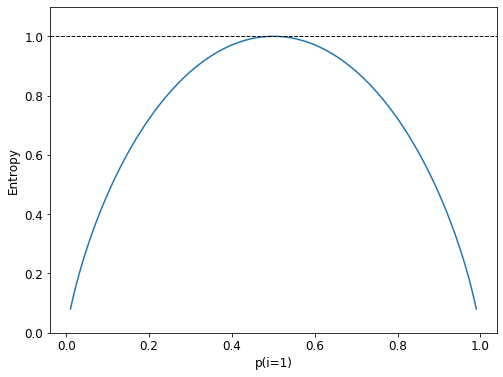

In [2]:
def entropy(p):
  return -p * np.log2(p) -(1-p) * np.log2(1-p)

plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
plt.plot(x, ent)
plt.axhline(y = 1.0, linewidth = 1, color = 'k', linestyle = '--')
plt.ylim([ 0, 1.1 ])
plt.xlabel('p(i=1)')
plt.ylabel('Entropy');

In [3]:
print(f'Entropy P(0.0000001): {entropy(0.0000001):.6f}')
print(f'Entropy P(0.5): {entropy(0.5)}')
print(f'Entropy P(0.9999999): {entropy(0.9999999):.6f}')

Entropy P(0.0000001): 0.000002
Entropy P(0.5): 1.0
Entropy P(0.9999999): 0.000002


The entropy is 0 if all samples of a node belong to the same class, and the entropy is maximal if we have a uniform class distribution. In other words, the entropy of a node (consist of single class) is zero because the probability is 1 and log (1) = 0. Entropy reaches maximum value when all classes in the node have equal probability.

1. Entropy of a group in which all examples belong to the same class:

$$entropy = -1\;log_2 \,1\,=0$$

1. Entropy of a group with 50% in either class:

$$entropy = -0.5\;log_2\,0.5\,-0.5\;log_2\,0.5=1$$

This is a good set for training.
So, basically, the entropy attempts to maximize the mutual information (by constructing a equal probability node) in the decision tree.

### Gini Index

Gini Index is defined as:

$$
\begin{align*}
I_G(t) &= \sum_{i =1}^{C} p(i \mid t) \big(1-p(i \mid t)\big) \nonumber \\ 
       &= \sum_{i =1}^{C} p(i \mid t) - p(i \mid t)^2 \nonumber \\ 
       &= \sum_{i =1}^{C} p(i \mid t) - \sum_{i =1}^{C} p(i \mid t)^2 \nonumber \\ 
       &= 1 - \sum_{i =1}^{C} p(i \mid t)^2
\end{align*}
$$

Compared to Entropy, the maximum value of the Gini index is 0.5, which occurs when the classes are perfectly balanced in a node. On the other hand, the minimum value of the Gini index is 0 and occurs when there is only one class represented in a node (A node with a lower Gini index is said to be more "pure").

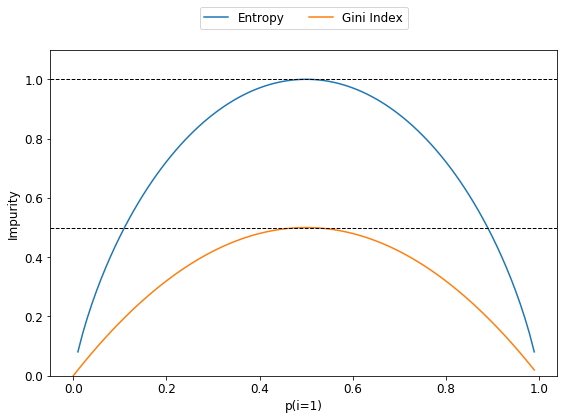

In [4]:
def gini(p):
  return p * (1 - p) + (1 - p) * (1 - (1 - p))

gi = gini(x)

# plot
for i, lab in zip([ent, gi], ['Entropy', 'Gini Index']):
    plt.plot(x, i, label = lab)

plt.legend(loc = 'upper center', bbox_to_anchor = (0.5, 1.15),
           ncol = 3, fancybox = True, shadow = False)
plt.axhline(y = 0.5, linewidth = 1, color = 'k', linestyle = '--')
plt.axhline(y = 1.0, linewidth = 1, color = 'k', linestyle = '--')
plt.ylim([ 0, 1.1 ])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity')
plt.tight_layout()

As we can see from the plot, there is not much differences (as in they both increase and decrease at similar range). In practice, Gini Index and Entropy typically yield very similar results and it is often not worth spending much time on evaluating decision tree models using different impurity criteria. As for which one to use, maybe consider Gini Index, because this way, we don’t need to compute the log, which can make it a bit computationly faster.

Decision trees can also be used on regression task. It's just instead of using gini index or entropy as the impurity function, we use criteria such as MSE (mean square error):

$$I_{MSE}(t) = \frac{1}{N_t} \sum_i^{N_t}(y_i - \bar{y})^2$$

Where $\bar{y}$ is the averages of the response at node $t$, and $N_t$ is the number of observations that reached node $t$. This is simply saying, we compute the differences between all $N_t$ observation's reponse to the average response, square it and take the average.

### Sample Scenario

Here we'll calculate the Entropy score by hand to hopefully make things a bit more concrete. Using the bank loan example again, suppose at a particular node, there are 80 observations, of whom 40 were classified as Yes (the bank will issue the loan) and 40 were classified as No.

We can first calculate the Entropy before making a split:

$$I_E(D_{p}) = - \left( \frac{40}{80} log_2(\frac{40}{80}) + \frac{40}{80} log_2(\frac{40}{80}) \right) = 1$$

Suppose we try splitting on Income and the child nodes turn out to be.

- Left (Income = high): 30 Yes and 10 No
- Right (Income = low): 10 Yes and 30 No

$$I_E(D_{left}) = - \left( \frac{30}{40} log_2(\frac{30}{40}) + \frac{10}{40} log_2(\frac{10}{40}) \right) = 0.81$$
$$I_E(D_{right}) = - \left( \frac{10}{40} log_2(\frac{10}{40}) + \frac{30}{40} log_2(\frac{30}{40}) \right) = 0.81$$
$$IG(D_{p}, Income) = 1 - \frac{40}{80} (0.81) - \frac{40}{80} (0.81) = 0.19$$

Next we repeat the same process and evaluate the split based on splitting by Credit.

- Left (Credit = excellent): 20 Yes and 0 No
- Right (Credit = poot): 20 Yes and 40 No

$$I_E(D_{left}) = - \left( \frac{20}{20} log_2(\frac{20}{20}) + \frac{0}{20} log_2(\frac{0}{20}) \right) = 0$$
$$I_E(D_{right}) = - \left( \frac{20}{60} log_2(\frac{20}{60}) + \frac{40}{60} log_2(\frac{40}{60}) \right) = 0.92$$
$$IG(D_{p}, Credit) = 1 - \frac{20}{80} (0) - \frac{60}{80} (0.92) = 0.31$$

In this case, it will choose Credit as the feature to split upon.

If we were to have more features, the decision tree algorithm will simply try every possible split, and will choose the split that maximizes the information gain. If the feature is a continuous variable, then we can simply get the unique values of that feature in a sorted order, then try all possible split values (threshold) by using cutoff point (average) between every two values (e.g. a unique value of 1, 2, 3 will result in trying the split on the value 1.5 and 2.5). Or to speed up computations, we can bin the unqiue values into buckets, and split on the buckets.

## Visualizing a Decision Tree

In [5]:
# load a sample dataset
iris = load_iris()
X = iris.data
y = iris.target
clf = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 10, max_depth = 3)
clf.fit(X, y)
y_pred = clf.predict(X)
print('classification distribution: ', np.bincount(y_pred))
print('accuracy score: ', accuracy_score(y, y_pred))

classification distribution:  [50 48 52]
accuracy score:  0.9733333333333334


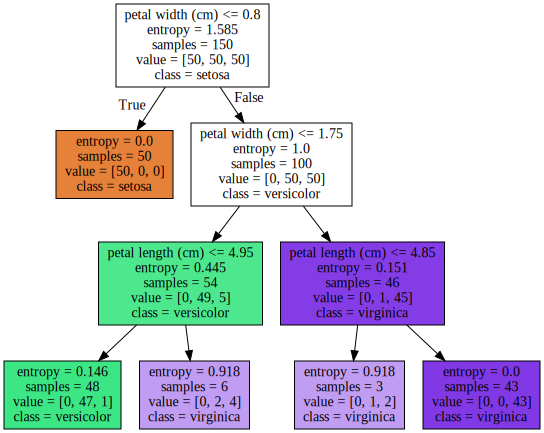

In [6]:
# visualize the decision tree

# export it as .dot file, other common parameters include
# `rounded` (boolean to round the score on each node)
export_graphviz(clf, feature_names = iris.feature_names, filled = True,
                class_names = iris.target_names, out_file = 'tree.dot')

# read it in and visualize it, or if we wish to
# convert the .dot file into other formats, we can do:
# import os
# os.system('dot -Tpng tree.dot -o tree.jpeg')
with open('tree.dot') as f:
    dot_graph = f.read()

Source(dot_graph)